<a href="https://colab.research.google.com/github/PolinaTiugaeva/mfdp/blob/main/improve_game_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rectools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successfully uninstalled attrs-24.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


In [2]:
import os
import threadpoolctl
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from rectools.metrics import Precision, Recall, calc_metrics
from rectools.models import ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Чтение датасета с рекомендациями
df_rec = pd.read_csv("/content/drive/MyDrive/recommendations.csv",
                     low_memory=False,
                     parse_dates=["date"]
                     )
df_rec = df_rec[(df_rec['date'].dt.year == 2022) & (df_rec['date'].dt.month == 12)]
df_rec.shape

(1002583, 8)

In [5]:
df_rec.describe()

,app_id,helpful,funny,date,hours,user_id,review_id
count,1.002583e+06,1.002583e+06,1.002583e+06,1002583,1.002583e+06,1.002583e+06,1.002583e+06
mean,9.917875e+05,3.198174e+00,7.166708e-01,2022-12-16 16:17:28.376842496,7.334235e+01,6.632976e+06,1.725251e+07
min,1.000000e+01,0.000000e+00,0.000000e+00,2022-12-01 00:00:00,0.000000e+00,1.700000e+01,0.000000e+00
25%,3.943600e+05,0.000000e+00,0.000000e+00,2022-12-08 00:00:00,7.600000e+00,3.106728e+06,5.850624e+06
50%,1.057090e+06,0.000000e+00,0.000000e+00,2022-12-17 00:00:00,2.320000e+01,5.925830e+06,1.574674e+07
75%,1.517290e+06,0.000000e+00,0.000000e+00,2022-12-25 00:00:00,7.230000e+01,1.036143e+07,2.663470e+07
max,2.253290e+06,1.341000e+04,2.947000e+03,2022-12-31 00:00:00,9.999000e+02,1.430600e+07,4.115476e+07
std,6.183346e+05,5.056078e+01,1.405692e+01,NaN,1.345964e+02,4.176066e+06,1.210931e+07


In [6]:
users = pd.read_csv("/content/drive/MyDrive/users.csv")
games = pd.read_csv("/content/drive/MyDrive/games.csv")
games_meta = pd.read_json("/content/drive/MyDrive/games_metadata_new.json")

In [7]:
games_meta.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [8]:
users.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [9]:
games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


# Feature engineering

In [10]:
df_rec['weight'] = np.where(df_rec.is_recommended == True, 1, 0)
df_rec = df_rec.drop('is_recommended', axis=1)
df_rec = df_rec.rename({'app_id' : 'item_id', 'date' : 'datetime'}, axis=1)

In [11]:
# Разделение на train и test
test = df_rec[df_rec.datetime >= df_rec['datetime'].quantile(q=0.8)]
train = df_rec[df_rec.datetime < df_rec['datetime'].quantile(q=0.8)]
train = train[train.hours > 1]

In [12]:
games_meta = games_meta.rename({'app_id' : 'item_id'}, axis=1)
user_tags = train[train['weight'] == 1][['user_id', 'item_id']].merge(games_meta[['item_id', 'tags']], on='item_id')
user_tags = user_tags.groupby('user_id')['tags'].sum().reset_index()
user_tags = user_tags[['user_id', 'tags']].explode('tags').fillna('Unknown')
user_tags

,user_id,tags
0,17,Unknown
1,23,Simulation
1,23,Action
1,23,Indie
1,23,Crime
...,...,...
505538,14305949,Unknown
505539,14305970,Unknown
505540,14305987,Unknown
505541,14305997,Unknown


In [13]:
df_rec['year'] = df_rec['datetime'].dt.year
df_rec['month'] = df_rec['datetime'].dt.month

In [14]:
reviews_month_total = df_rec.groupby(['user_id', 'year', 'month']).size().reset_index(name='size').groupby('user_id')['size'].mean()
reviews_month_total

,size
user_id,
17,1.0
23,1.0
30,1.0
36,2.0
81,1.0
...,...
14305949,1.0
14305970,1.0
14305987,1.0


In [15]:
reviews_month_positive = df_rec.groupby(['user_id', 'year', 'month'])['weight'].sum().reset_index(name='sum').groupby('user_id')['sum'].mean()
reviews_month_positive

,sum
user_id,
17,1.0
23,1.0
30,1.0
36,2.0
81,0.0
...,...
14305949,1.0
14305970,1.0
14305987,1.0


In [16]:
cold_users = set(test['user_id']) - set(train['user_id'])
print(f"Количество 'холодных' пользователей в тестовой выборке - {len(cold_users)}")

Количество 'холодных' пользователей в тестовой выборке - 175462


In [17]:
test.drop(test[test['user_id'].isin(cold_users)].index, inplace=True)
test_users = test['user_id'].unique()
print(f"Количество уникальных пользователей в тестовой выборке - {len(test_users)}")

Количество уникальных пользователей в тестовой выборке - 33773


In [18]:
catalog=train['item_id'].unique()
print(f"Количество игр в обучающей выборке - {len(catalog)}")

Количество игр в обучающей выборке - 13433


In [19]:
users.isna().sum()

,0
user_id,0
products,0
reviews,0


In [20]:
users = users.loc[users['user_id'].isin(train['user_id'])].copy()
user_tags.columns = ["id", "value"]
user_tags["feature"] = "tag"
reviews_month_total.columns = ["id", "value"]
reviews_month_total["feature"] = "reviews_month_total"
reviews_month_positive.columns = ["id", "value"]
reviews_month_positive["feature"] = "reviews_month_positive"
user_features = pd.concat((user_tags, reviews_month_total, reviews_month_positive))
del user_tags, reviews_month_total, reviews_month_positive

In [21]:
games.isna().sum()

,0
app_id,0
title,0
date_release,0
win,0
mac,0
linux,0
rating,0
positive_ratio,0
user_reviews,0
price_final,0


In [22]:
# К фичам игр добавляю теги, месяц и год рилиза
games = games.rename({'app_id' : 'item_id'}, axis=1)
games = games.merge(games_meta[['item_id', 'tags']], on="item_id")
games['date_release'] = pd.to_datetime(games['date_release'])
games['year_release'] = games['date_release'].dt.year
games['month_release'] = games['date_release'].dt.month
games = games.drop(['title', 'price_original', 'discount', 'steam_deck', 'date_release'], axis=1)
games.head()

,item_id,win,mac,linux,rating,positive_ratio,user_reviews,price_final,tags,year_release,month_release
0,13500,True,False,False,Very Positive,84,2199,9.99,"[Action, Adventure, Parkour, Third Person, Gre...",2008,11
1,22364,True,False,False,Positive,85,21,2.99,[Action],2011,8
2,113020,True,True,True,Very Positive,92,3722,14.99,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St...",2013,4
3,226560,True,False,False,Mixed,61,873,14.99,"[Zombies, Adventure, Survival, Action, Third P...",2014,11
4,249050,True,True,False,Very Positive,88,8784,11.99,"[Roguelike, Strategy, Tower Defense, Pixel Gra...",2014,10


In [23]:
# Process item features to the form of a flatten dataframe
games = games.loc[games['item_id'].isin(train['item_id'])].copy()
# Year release
year_feature = games.reindex(columns = ['item_id', 'year_release'])
year_feature.columns = ["id", "value"]
year_feature["feature"] = "year"
# Month release
month_feature = games.reindex(columns = ['item_id', 'month_release'])
month_feature.columns = ["id", "value"]
month_feature["feature"] = "month"
# Rating
rating_feature = games.reindex(columns=['item_id', 'rating'])
rating_feature.columns = ["id", "value"]
rating_feature['feature'] = "rating"
# tags
tags_feature = games.reindex(columns=['item_id', 'tags'])
tags_feature = tags_feature[['item_id', 'tags']].explode('tags')
tags_feature.columns = ["id", "value"]
tags_feature['feature'] = "tag"
# Plarform
platform_feature_frames = []
for column in ['win', 'mac', 'linux']:
  platform_feature_frame = games.reindex(columns=['item_id', column])
  platform_feature_frame = platform_feature_frame[platform_feature_frame[column] == True]
  platform_feature_frame.columns = ['id', 'value']
  platform_feature_frame['value'] = column
  platform_feature_frames.append(platform_feature_frame)

platform_feature = pd.concat(platform_feature_frames)
platform_feature['feature'] = 'platform'
game_features = pd.concat((year_feature, month_feature, tags_feature, rating_feature, platform_feature))
del platform_feature_frames, year_feature, rating_feature, platform_feature, month_feature, tags_feature

In [24]:
user_features = user_features.drop(['size', 'sum'], axis=1)
user_features.head()

,id,value,feature
0,17.0,Unknown,tag
1,23.0,Simulation,tag
1,23.0,Action,tag
1,23.0,Indie,tag
1,23.0,Crime,tag


In [25]:
game_features.head()

,id,value,feature
0,13500,2008,year
2,113020,2013,year
3,226560,2014,year
4,249050,2014,year
5,250180,2015,year


# Datasets

In [26]:
dataset_no_features = Dataset.construct(
    interactions_df=train,
)

dataset_full_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=['tag'],
    item_features_df=game_features,
    cat_item_features=["rating", "platform", "tag"],
)

dataset_item_features = Dataset.construct(
    interactions_df=train,
    item_features_df=game_features,
    cat_item_features=["rating", "platform", "tag"],
)

dataset_user_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=['tag'],
)

feature_datasets = {
    "full_features": dataset_full_features,
    "item_features": dataset_item_features,
    "user_features": dataset_user_features
}

In [27]:
# Prepare dataset with biases as features

item_biases = pd.DataFrame({
    "id": catalog,
    "bias": 1
})
user_biases = pd.DataFrame({
    "id": train['user_id'].unique(),
    "bias": 1
})

dataset_with_biases = Dataset.construct(
    interactions_df=train,
    user_features_df=user_biases,
    make_dense_user_features=True,
    item_features_df=item_biases,
    make_dense_item_features=True
)
feature_datasets["biases"] = dataset_with_biases

In [28]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall


}
metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (5, 10, 15):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [29]:
K_RECOS = 10
NUM_THREADS = 32
RANDOM_STATE = 32
ITERATIONS = 10

In [30]:
def make_base_model(factors: int, regularization: float, alpha: float, fit_features_together: bool=False):
    return ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads = NUM_THREADS,
            iterations=ITERATIONS),
        fit_features_together = fit_features_together,
        )

In [31]:
alphas = [1, 10, 100]
regularizations = [0.01, 0.1, 0.5]
factors = [32, 64, 128]

In [32]:
results = []
dataset = dataset_no_features

for alpha in alphas:
    for regularization in regularizations:
        for n_factors in factors:
            model_name = f"no_features_factors_{n_factors}_alpha_{alpha}_reg_{regularization}"
            model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            results.append(metric_values)

In [33]:
pure_df = pd.DataFrame(results).set_index("model").sort_values(by=["Precision@15", "Recall@15"], ascending=False)
pure_df.head(5)

,Precision@5,Precision@10,Precision@15,Recall@5,Recall@10,Recall@15
model,,,,,,
no_features_factors_32_alpha_1_reg_0.01,0.008948,0.007447,0.004965,0.036671,0.060989,0.060989
no_features_factors_32_alpha_1_reg_0.1,0.008978,0.007438,0.004959,0.036632,0.060925,0.060925
no_features_factors_32_alpha_1_reg_0.5,0.009084,0.007408,0.004939,0.037096,0.060479,0.060479
no_features_factors_32_alpha_10_reg_0.5,0.008285,0.006937,0.004625,0.034448,0.056820,0.056820
no_features_factors_32_alpha_10_reg_0.1,0.008267,0.006875,0.004584,0.034387,0.056298,0.056298


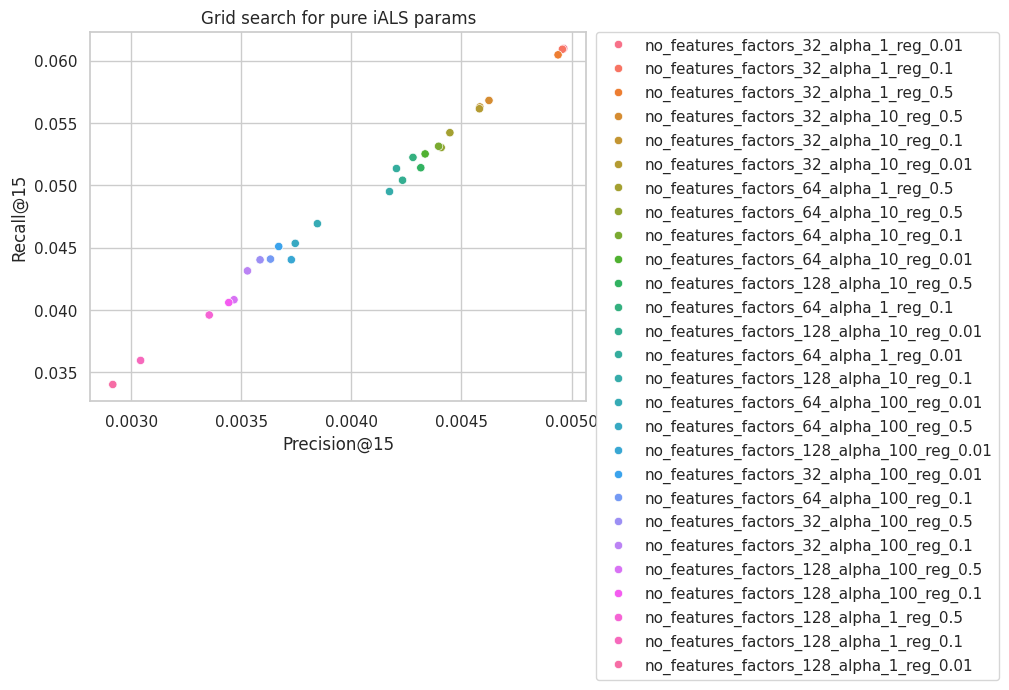

In [34]:
sns.scatterplot(data = pure_df, x="Precision@15", y="Recall@15", hue="model", legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Grid search for pure iALS params")
plt.show()

In [35]:
# Best grid search params for pure iALS models
n_factors = 32
ALPHA = 1
REG = (0.01, 0.1, 0.5)

# We have two options for training iALS with features in RecTools
fit_features_together = (True, False)

# We have datasets with different feature selections
feature_datasets.keys()

dict_keys(['full_features', 'item_features', 'user_features', 'biases'])

In [36]:
features_results = []
for dataset_name, dataset in feature_datasets.items():
    for reg in REG:
        for features_option in fit_features_together:
            model_name = f"{dataset_name}_factors_{n_factors}_fit_together_{features_option}"
            model = make_base_model(factors = n_factors, regularization=reg, alpha=ALPHA, fit_features_together=features_option)
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            features_results.append(metric_values)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
features_df = (
    pd.DataFrame(features_results)
    .set_index("model")
    .sort_values(by=["Precision@15", "Recall@15"], ascending=False)
)
features_df.head(5)

,Precision@5,Precision@10,Precision@15,Recall@5,Recall@10,Recall@15
model,,,,,,
biases_factors_32_fit_together_False,0.006603,0.007014,0.004676,0.028063,0.059115,0.059115
biases_factors_32_fit_together_False,0.006621,0.006988,0.004659,0.028167,0.058922,0.058922
biases_factors_32_fit_together_False,0.006544,0.006979,0.004653,0.027855,0.058887,0.058887
user_features_factors_32_fit_together_False,0.007379,0.006819,0.004546,0.031063,0.056364,0.056364
user_features_factors_32_fit_together_False,0.007373,0.006792,0.004528,0.031027,0.056402,0.056402


In [38]:
# prepare info for summary plot
no_features_best_models = [
    "no_features_factors_32_alpha_1_reg_0.01",
    "no_features_factors_32_alpha_1_reg_0.1",
    "no_features_factors_32_alpha_1_reg_0.5"
]

pure_df["step"] = "1. pure iALS no features grid search"
pure_df.loc[pure_df.index.isin(no_features_best_models), "step"] = "2. pure iALS no features best models"
features_df["step"] = "3. iALS with user / item features"
all_df = pd.concat([features_df, pure_df])
all_df.head()

,Precision@5,Precision@10,Precision@15,Recall@5,Recall@10,Recall@15,step
model,,,,,,,
biases_factors_32_fit_together_False,0.006603,0.007014,0.004676,0.028063,0.059115,0.059115,3. iALS with user / item features
biases_factors_32_fit_together_False,0.006621,0.006988,0.004659,0.028167,0.058922,0.058922,3. iALS with user / item features
biases_factors_32_fit_together_False,0.006544,0.006979,0.004653,0.027855,0.058887,0.058887,3. iALS with user / item features
user_features_factors_32_fit_together_False,0.007379,0.006819,0.004546,0.031063,0.056364,0.056364,3. iALS with user / item features
user_features_factors_32_fit_together_False,0.007373,0.006792,0.004528,0.031027,0.056402,0.056402,3. iALS with user / item features


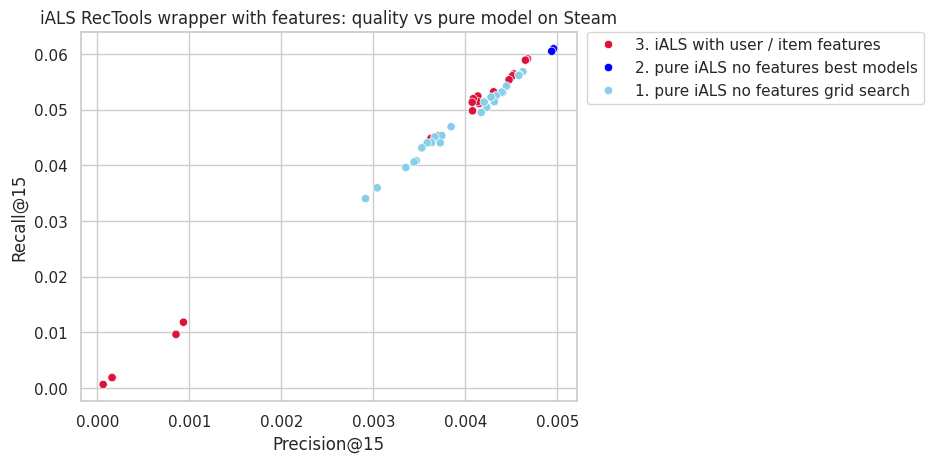

In [39]:
sns.scatterplot(data = all_df, x="Precision@15", y="Recall@15", hue="step",
                palette=["crimson", "blue", "skyblue"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("iALS RecTools wrapper with features: quality vs pure model on Steam")
plt.show()

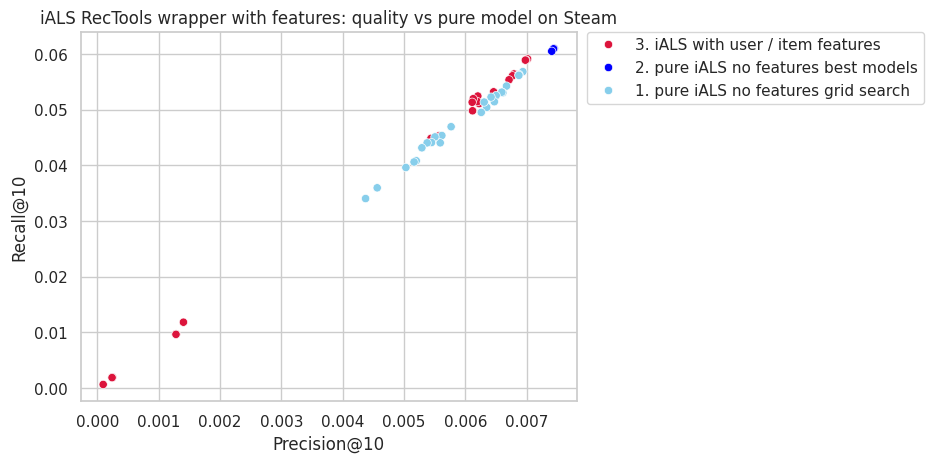

In [40]:
sns.scatterplot(data = all_df, x="Precision@10", y="Recall@10", hue="step",
                palette=["crimson", "blue", "skyblue"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("iALS RecTools wrapper with features: quality vs pure model on Steam")
plt.show()

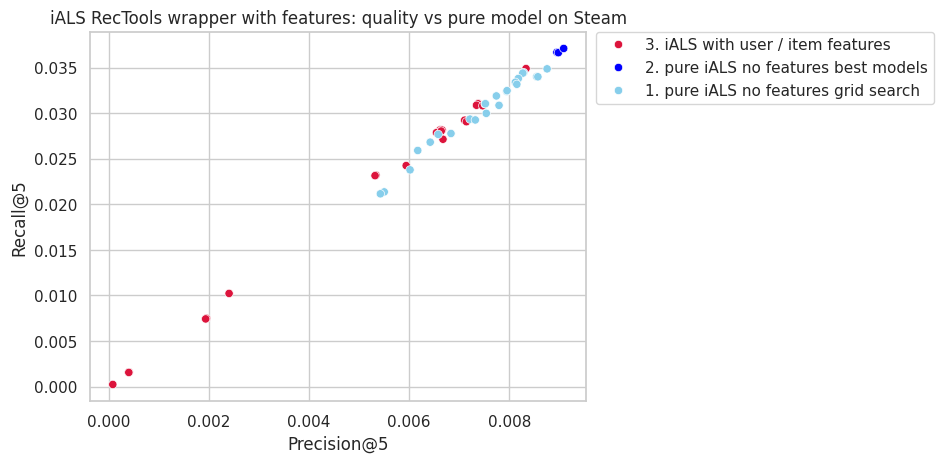

In [41]:
sns.scatterplot(data = all_df, x="Precision@5", y="Recall@5", hue="step",
                palette=["crimson", "blue", "skyblue"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("iALS RecTools wrapper with features: quality vs pure model on Steam")
plt.show()